In [1]:
import hail as hl

from bge_toolkit.qc import JointCallSet, ConcordanceTable, Statistic, ALL_AGG, ALL_GROUP, JoinType
from bge_toolkit.common import mac_bin, maf_bin, max_gp_bin, gq_bin, qual_approx_bin, info_score_bin, dp_bin


hl.init(driver_cores=2)

out_dir = 'gs://my-bucket/test-concordance/test-chr1'

Loading BokehJS ...

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/hail/backend/service_backend.py:564: UserWarning: Modifying the requester pays project or buckets at runtime using flags is deprecated. Expect this behavior to become unsupported soon.
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.134-952ae203dbbe
LOGGING: writing to /Users/jigold/projects/bge-toolkit/notebooks/hail-20250509-1503-0.2.134-952ae203dbbe.log


## Create Joint Callset

In [21]:
exo = hl.read_matrix_table("gs://my-bucket/PUMAS1_DragenData_BGE_Callset1.mt")

exo = exo.filter_rows(exo.locus.contig == 'chr1')

exo = hl.split_multi(exo)

exo = exo.annotate_rows(AC=hl.agg.sum(exo.GT.n_alt_alleles()))

exo = exo.annotate_rows(AF=hl.agg.sum(exo.GT.n_alt_alleles()) / (2 * hl.agg.count_where(hl.is_defined(exo.GT))))

exo = exo.annotate_entries(DP=hl.sum(exo.AD))

exo = exo.annotate_rows(QUALapprox=exo.info.QUALapprox)

exo.describe()

INFO:hailtop.aiocloud.aiogoogle.credentials:using credentials file /Users/jigold/.config/gcloud/application_default_credentials.json: ApplicationDefaultCredentials
INFO:batch_client.aioclient:created batch 8255661


Output()

INFO:batch_client.aioclient:updated batch 8255661


Output()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        AS_QUALapprox: str, 
        CALIBRATION_SENSITIVITY: array<str>, 
        QUALapprox: int32, 
        SCORE: array<str>
    }
    'a_index': int32
    'was_split': bool
    'old_locus': locus<GRCh38>
    'old_alleles': array<str>
    'AC': int64
    'AF': float64
    'QUALapprox': int32
----------------------------------------
Entry fields:
    'AD': array<int32>
    'FT': str
    'GQ': int32
    'GT': call
    'PGT': call
    'PID': str
    'PS': int32
    'RGQ': int32
    'DP': int32
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
--------------

In [22]:
imp = hl.read_matrix_table("gs://my-bucket/glimpse-pumas-GPC-psychosis-v2.chr1.mt")
imp = imp.filter_rows(imp.locus.contig == 'chr1')
imp = hl.split_multi(imp)

imp = imp.annotate_rows(
            AF=hl.agg.sum(imp.GT.n_alt_alleles()) / (2 * hl.agg.count_where(hl.is_defined(imp.GT))))

imp = imp.annotate_rows(AC=hl.agg.sum(imp.GT.n_alt_alleles()))

imp = imp.annotate_rows(INFO=imp.info.INFO, RAF=imp.info.RAF)

imp = imp.annotate_entries(MAX_GP=hl.max(imp.GP))

imp.describe()

INFO:batch_client.aioclient:updated batch 8255661


Output()

INFO:batch_client.aioclient:updated batch 8255661


Output()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AF: float64, 
        INFO: float64, 
        RAF: float64
    }
    'a_index': int32
    'was_split': bool
    'old_locus': locus<GRCh38>
    'old_alleles': array<str>
    'AF': float64
    'AC': int64
    'INFO': float64
    'RAF': float64
----------------------------------------
Entry fields:
    'DS': float64
    'GP': array<float64>
    'GT': call
    'MAX_GP': float64
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [23]:
joint_callset = JointCallSet(exo, imp)

## Get number of overlaps of the two datasets

In [6]:
joint_callset.n_sample_overlaps

    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
INFO:batch_client.aioclient:updated batch 8254982


Output()

INFO:batch_client.aioclient:updated batch 8254982


Output()

4967

In [38]:
joint_callset.sample_overlaps().describe()

INFO:batch_client.aioclient:updated batch 8255662


Output()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'EXOME': bool 
    'IMPUTATION': bool 
----------------------------------------
Key: ['s']
----------------------------------------


In [8]:
joint_callset.sample_overlaps().export('gs://my-bucket/test-concordance/test-chr1/sample_overlaps.tsv')

INFO:batch_client.aioclient:updated batch 8254982


Output()

In [ ]:
### This is expensive!

# joint_callset.variant_overlaps().head(10)
# print(joint_callset.n_variant_overlaps)

## Compute Global Concordance

In [25]:
def custom_maf_bin(s: hl.StructExpression):
    maf_bin = (hl.case()
               .when(s.AF <= 0.001, '<0.1%')
               .when(s.AF <= 0.01, '0.1-1%')
               .when(s.AF <= 0.02, '1-2%')
               .when(s.AF <= 0.05, '2-5%')
               .default('>5%'))
    return maf_bin



exo_row_group_by_var = {'exo_mac': mac_bin, 'exo_maf': custom_maf_bin}
imp_row_group_by_var = {'INFO': info_score_bin, 'RAF': custom_maf_bin, 'imp_maf': custom_maf_bin}

exo_row_agg_fields = {'qual_approx': qual_approx_bin}
imp_row_agg_fields = {'INFO': info_score_bin}

exo_entry_agg_fields = {'DP': dp_bin, 'GQ': gq_bin}
imp_entry_agg_fields = {'MAX_GP': max_gp_bin}

global_conc = joint_callset.global_concordance(exo_row_group_by_var=exo_row_group_by_var,
                                               imp_row_group_by_var=imp_row_group_by_var,
                                               exo_entry_agg_fields=exo_entry_agg_fields,
                                               imp_entry_agg_fields=imp_entry_agg_fields,
                                               exo_row_agg_fields=exo_row_agg_fields,
                                               imp_row_agg_fields=imp_row_agg_fields,
                                               join_type=JoinType.inner)

global_conc.write(f'{out_dir}/global_conc.ht')

    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
INFO:hailtop.aiocloud.aiogoogle.credentials:using credentials file /Users/jigold/.config/gcloud/application_default_credentials.json: ApplicationDefaultCredentials
INFO:batch_client.aioclient:created batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

## Save and Load Raw Data into a ConcordanceTable Object

In [26]:
global_conc = ConcordanceTable.load(f'{out_dir}/global_conc.ht')

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

## View ConcordanceTable Properties

In [27]:
global_conc.group_vars()

INFO:batch_client.aioclient:updated batch 8255662


Output()

{'ALL': dtype('str'),
 'INFO': dtype('float64'),
 'RAF': dtype('str'),
 'exo_mac': dtype('str'),
 'exo_maf': dtype('str'),
 'imp_maf': dtype('str')}

In [28]:
global_conc.agg_vars()

INFO:batch_client.aioclient:updated batch 8255662


Output()

{'ALL': dtype('str'),
 'DP': dtype('int32'),
 'GQ': dtype('int32'),
 'INFO': dtype('float64'),
 'MAX_GP': dtype('float64'),
 'qual_approx': dtype('int32')}

## Obtain a View of the Concordance Output

In [49]:
maf_ordering = ['<0.1%', '0.1-1%', '1-2%', '2-5%', '>5%']
mac_ordering = ['1', '2-5', '6-10', '10+']


ordering = {'exo_maf': maf_ordering, 'imp_maf': maf_ordering, 'RAF': maf_ordering,
            'exo_mac': mac_ordering, 'imp_mac': mac_ordering}

exo_maf_view = global_conc.get_view(group_names=['exo_maf'], 
                                    agg_names=[ALL_AGG, 'GQ', 'DP', 'MAX_GP', 'INFO', 'qual_approx'], 
                                    ordering=ordering)

imp_maf_view = global_conc.get_view(group_names=['imp_maf'], 
                                    agg_names=[ALL_AGG, 'GQ', 'DP', 'MAX_GP', 'INFO', 'qual_approx'], 
                                    ordering=ordering)

imp_raf_view = global_conc.get_view(group_names=['RAF'], 
                                    agg_names=[ALL_AGG, 'GQ', 'DP', 'MAX_GP', 'INFO', 'qual_approx'], 
                                    ordering=ordering)

info_view = global_conc.get_view(group_names=['INFO'], 
                                 agg_names=[ALL_AGG, 'GQ', 'DP', 'MAX_GP', 'qual_approx'], 
                                 ordering=ordering)

all_view = global_conc.get_view(group_names=[ALL_GROUP, 'exo_maf', 'exo_mac', 'imp_maf', 'imp_mac', 'RAF'],
                                agg_names=[ALL_AGG, 'GQ', 'DP', 'MAX_GP', 'INFO', 'qual_approx'],
                                ordering=ordering)

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

## Make a Plot of Concordance with Non-Reference Concordance

INFO:batch_client.aioclient:updated batch 8255662


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


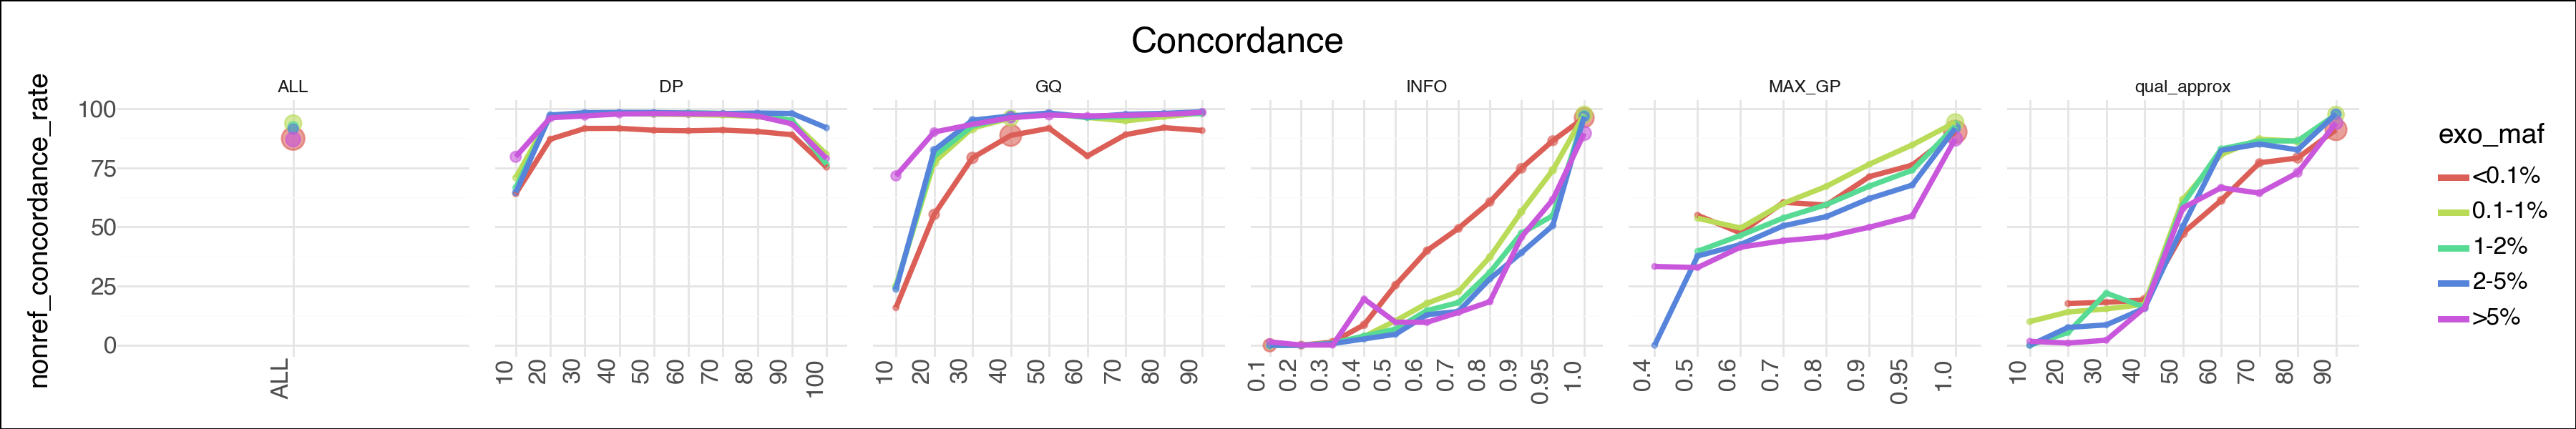

In [32]:
p = exo_maf_view.plot(statistic=Statistic.NONREF_CONCORDANCE)
display(p)

INFO:batch_client.aioclient:updated batch 8255662


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


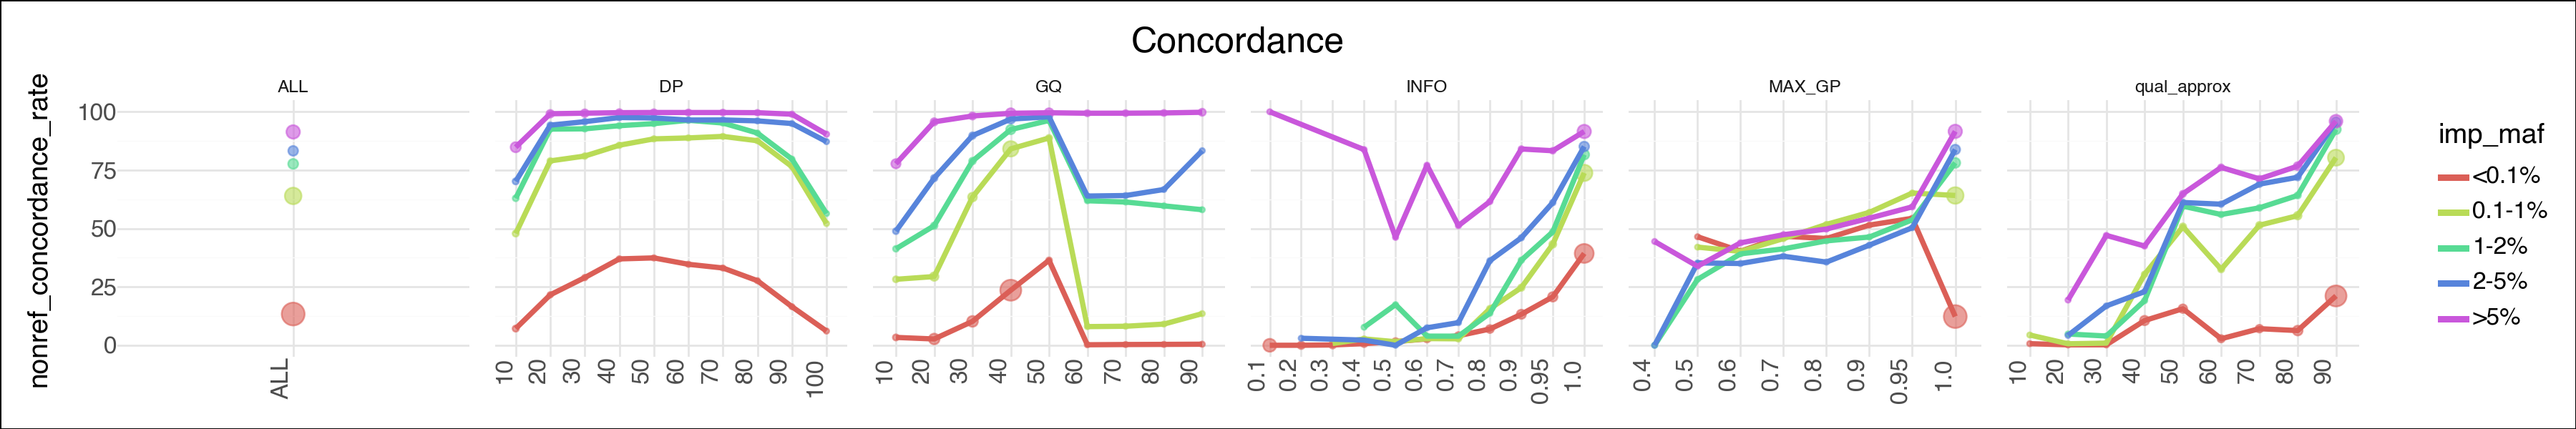

In [33]:
p = imp_maf_view.plot(statistic=Statistic.NONREF_CONCORDANCE)
display(p)

INFO:batch_client.aioclient:updated batch 8255662


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


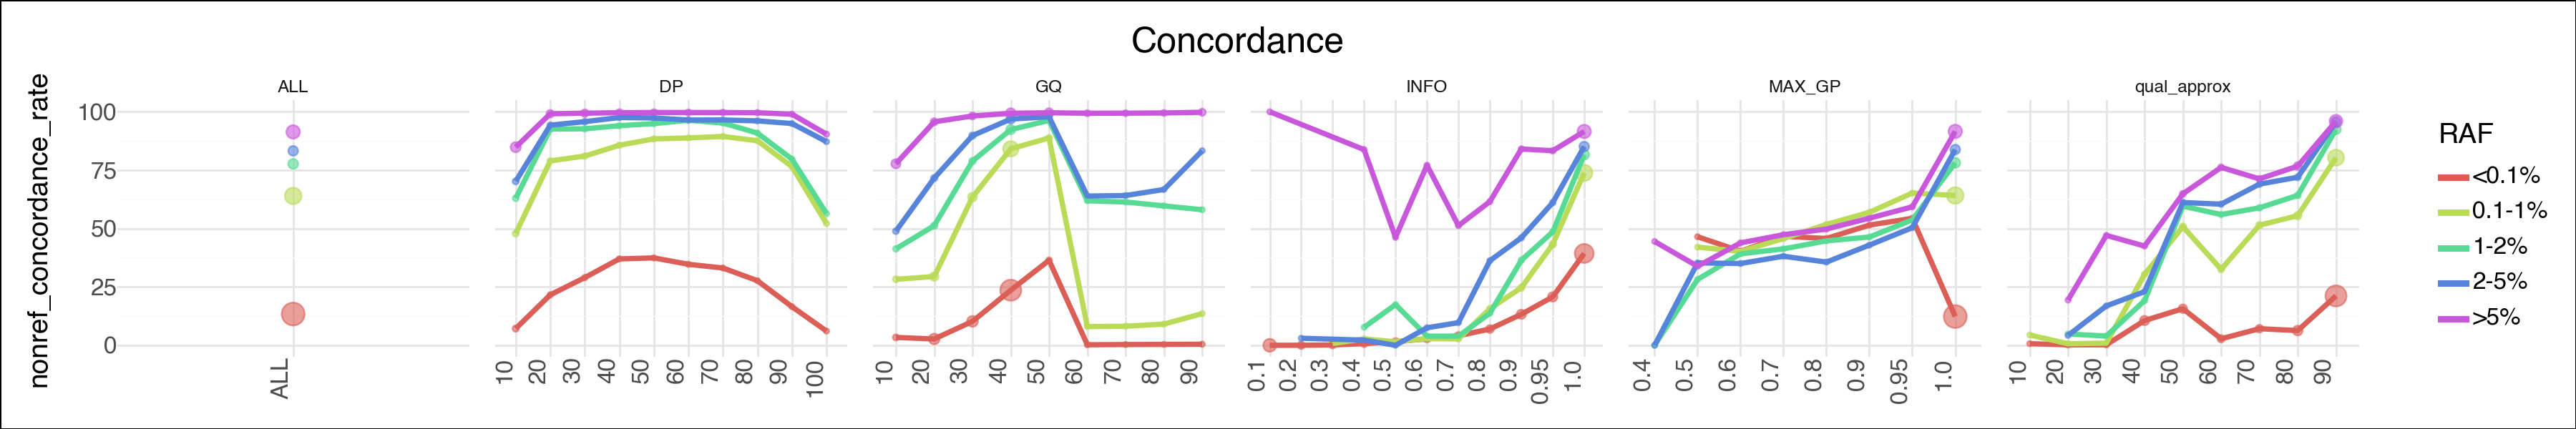

In [36]:
p = imp_raf_view.plot(statistic=Statistic.NONREF_CONCORDANCE)
display(p)

INFO:batch_client.aioclient:updated batch 8255662


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


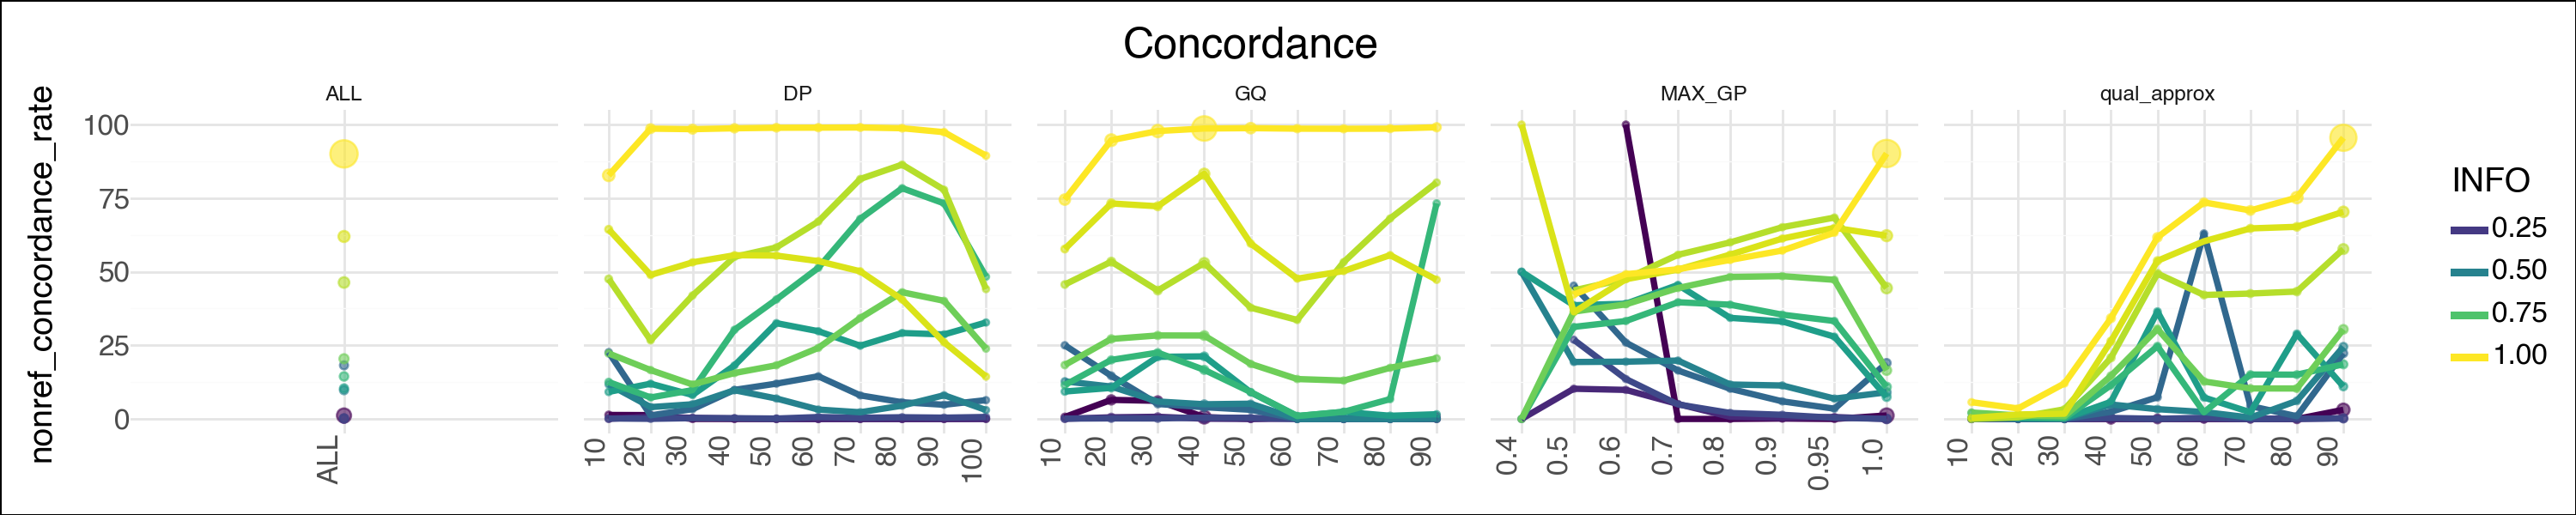

In [37]:
p = info_view.plot(statistic=Statistic.NONREF_CONCORDANCE)
display(p)

In [52]:
info_view.plot_all(out_dir=f'{out_dir}/plots/nonref-conc/', statistic=Statistic.NONREF_CONCORDANCE)
all_view.plot_all(out_dir=f'{out_dir}/plots/nonref-conc/', statistic=Statistic.NONREF_CONCORDANCE)

INFO:hailtop.aiocloud.aiogoogle.credentials:using credentials file /Users/jigold/.config/gcloud/application_default_credentials.json: ApplicationDefaultCredentials
INFO:batch_client.aioclient:created batch 8256160


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 3 in image.
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /var/folders/gj/9b51nf5s6mlc0p0wb6g9lgmc0000gq/T/tmpbyk7s5f_.png
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
INFO:hailtop.aiocloud.aiogoogle.credentials:using credentials file /Users/jigold/.config/gcloud/application_default_credentials.json: ApplicationDefaultCredentials
INFO:batch_client.aioclient:updated batch 8256160


Output()

/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 18 x 3 in image.
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /var/folders/gj/9b51nf5s6mlc0p0wb6g9lgmc0000gq/T/tmpnjmxwy_x.png
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/jigold/anaconda3/envs/bge-toolkit-test/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


{'ALL': <plotnine.ggplot.ggplot at 0x143c112b0>,
 'RAF': <plotnine.ggplot.ggplot at 0x145bdd4f0>,
 'exo_mac': <plotnine.ggplot.ggplot at 0x1413ec9b0>,
 'exo_maf': <plotnine.ggplot.ggplot at 0x14604dd00>,
 'imp_maf': <plotnine.ggplot.ggplot at 0x145cfa480>}

## Look at a Table of Results

In [42]:
exo_mac_dp_view = global_conc.get_view(group_names=['exo_mac'], agg_names=['DP'], ordering=ordering)
df = exo_mac_dp_view.result()

df['DP'] = df['agg_var']
df['exo_mac'] = df['group_var']

df = df[(df['exo_mac'] == '10+')]
df = df[['DP', 'n_variants', 'n_samples', 'n_total', 'nonref_concordance_rate', 'HET_HOMREF', 'HOMREF_HET']]

df

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

,DP,n_variants,n_samples,n_total,nonref_concordance_rate,HET_HOMREF,HOMREF_HET
10,10,164490,4967,31605720,79.51,757356,0
12,20,55848,4966,7525554,96.23,157695,0
13,30,53177,4961,8103117,97.03,141257,0
14,40,45738,4961,4927633,97.79,72173,0
15,50,33440,4959,2451647,97.92,36855,0
16,60,22488,4959,1379881,97.80,22622,0
17,70,14802,4956,743576,97.70,13457,0
18,80,9622,4949,329164,96.95,8694,0
19,90,6027,4910,128796,93.91,7037,0
11,100,4604,4822,92409,79.53,15334,0


## Look at the global concordance

In [43]:
all_view = global_conc.get_view(group_names=[ALL_GROUP], agg_names=[ALL_AGG])
all_view.result()[['n_variants', 'n_samples', 'n_total', 'nonref_concordance_rate', 'HET_HOMREF', 'HOMREF_HET']]

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

,n_variants,n_samples,n_total,nonref_concordance_rate,HET_HOMREF,HOMREF_HET
0,289040,4967,612353318,87.30,1269802,20992


## Look at a table with all of the aggregated results grouped by exo_mac

In [44]:
exo_mac_all_view = global_conc.get_view(group_names=['exo_mac'], agg_names=[ALL_AGG], ordering=ordering)
exo_mac_all_view.result()[['group_var', 'n_variants', 'n_samples', 'n_total', 'nonref_concordance_rate', 'HET_HOMREF', 'HOMREF_HET']]

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

,group_var,n_variants,n_samples,n_total,nonref_concordance_rate,HET_HOMREF,HOMREF_HET
0,1,12993,4967,58830196,76.90,1575,359
2,2-5,33923,4967,103304968,63.28,12791,959
3,6-10,31524,4967,54565943,52.02,22956,570
1,10+,210600,4967,395652211,87.35,1232480,19104


## Look at Concordance for Common Variants

In [46]:
exo_maf_view = global_conc.get_view(group_names=['exo_maf'], 
                                    agg_names=[ALL_AGG], 
                                    ordering=ordering)
exo_maf_view.result()[['group_var', 'n_variants', 'n_samples', 'n_total', 'nonref_concordance_rate', 'HET_HOMREF', 'HOMREF_HET']]

INFO:batch_client.aioclient:updated batch 8255662


Output()

INFO:batch_client.aioclient:updated batch 8255662


Output()

,group_var,n_variants,n_samples,n_total,nonref_concordance_rate,HET_HOMREF,HOMREF_HET
3,<0.1%,75283,4967,340074750,87.40,29287,3384
0,0.1-1%,51845,4967,140013801,93.80,53139,2733
1,1-2%,23293,4967,25217915,92.34,42956,1375
2,2-5%,35901,4967,22762186,91.40,85388,2750
4,>5%,102718,4967,84284666,86.99,1059032,10750


## Close JointCallset

In [47]:
joint_callset.close()